In [6]:
%pip install albumentations torch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Конфигурация и подготовка данных

В этом блокноте определены:
- Конфигурационные параметры (пути, гиперпараметры, размер изображений и т.д.)
- Аугментации с использованием Albumentations
- Класс датасета для сегментации УЗИ-слайсов


In [1]:
# Конфигурационные параметры

import os

# Пути к данным (рекомендуется создать папки data/cropped_images и data/cropped_masks)
BASE_DIR = os.path.join("d:/", "NartovFatSegm", "Nartov_Fat_Segmentation")
IMAGE_DIR = os.path.join(BASE_DIR, "data", "cropped_images")
MASK_DIR = os.path.join(BASE_DIR, "data", "cropped_masks")
LOG_DIR = os.path.join(BASE_DIR, "logs", "train")
MODEL_SAVE_PATH = os.path.join(BASE_DIR, "best_unet_model.pth")

# Параметры обучения
BATCH_SIZE = 4
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4
RANDOM_STATE = 42

# Размер входного изображения для сети (ширина, высота)
IMG_SIZE = (512, 512)

print("Конфигурация загружена")


Конфигурация загружена


In [2]:
# Определяем аугментации для обучения и валидации с использованием Albumentations.

import albumentations as A
from albumentations.pytorch import ToTensorV2

TRAIN_TRANSFORMS = A.Compose([
    A.RandomCrop(width=IMG_SIZE[0], height=IMG_SIZE[1], p=0.5),
    A.Resize(height=IMG_SIZE[1], width=IMG_SIZE[0]),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=[-15, 15], p=0.8),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.GaussNoise(p=0.5),
    A.ElasticTransform(alpha=300, sigma=10, p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

VAL_TRANSFORMS = A.Compose([
    A.Resize(height=IMG_SIZE[1], width=IMG_SIZE[0]),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])


Error importing huggingface_hub.hf_api: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)
Error importing huggingface_hub.file_download: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)
Error importing huggingface_hub.hf_api: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)


C:\Users\narto\AppData\Roaming\Python\Python38\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
#Класс датасета для сегментации ультразвуковых изображений

import glob
import os
import cv2
from torch.utils.data import Dataset

class UltrasoundSegmentationDataset(Dataset):
    """
    Dataset для сегментации УЗИ-слайсов с денойзингом на основе билатерального фильтра.
    
    Аргументы:
        images_dir (str): Путь к директории с изображениями.
        masks_dir (str): Путь к директории с масками.
        transform (callable, optional): Дополнительные аугментации, применяемые к данным.
        apply_bilateral (bool, optional): Если True, применяется билатеральное фильтрование для снижения спекл-шума.
        apply_clahe (bool, optional): Если True, после денойзинга применяется CLAHE для улучшения контраста.
    """
    
    def __init__(self, images_dir, masks_dir, transform=None,
                 apply_bilateral=True, apply_clahe=True):
        self.image_paths = sorted(glob.glob(os.path.join(images_dir, '*.png')))
        self.mask_paths = sorted(glob.glob(os.path.join(masks_dir, '*.png')))
        self.transform = transform
        self.apply_bilateral = apply_bilateral
        self.apply_clahe = apply_clahe

        if len(self.image_paths) != len(self.mask_paths):
            raise ValueError("Количество изображений и масок должно совпадать!")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Загружаем изображение и маску в градациях серого.
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Применяем билатеральное фильтрование для подавления спекл-шума.
        if self.apply_bilateral:
            image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
        
        # Применяем CLAHE для улучшения контраста.
        if self.apply_clahe:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            image = clahe.apply(image)
        
        # Применяем аугментации (если заданы).
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask


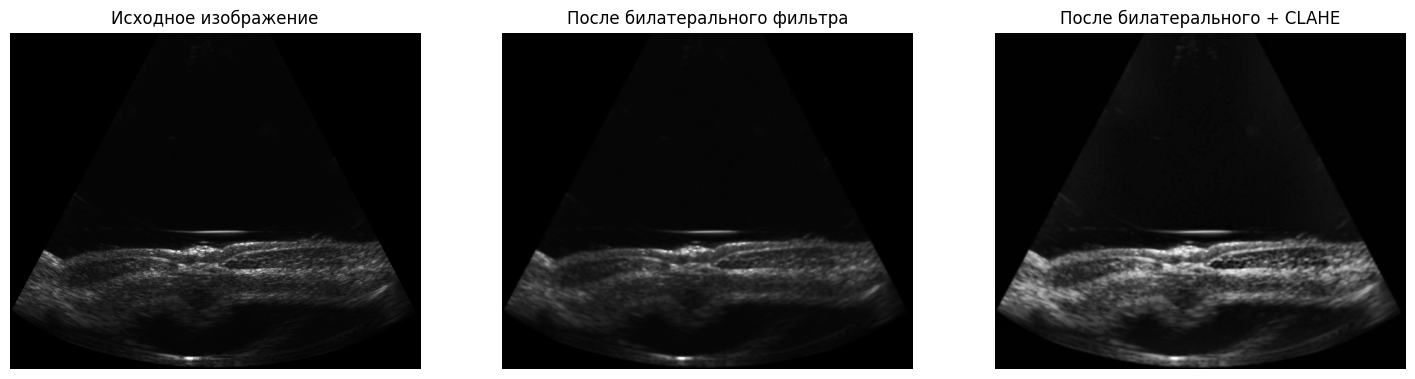

In [6]:
import cv2
import matplotlib.pyplot as plt
import os

# Путь к примерному изображению (обновите имя файла при необходимости)
example_path = os.path.join(BASE_DIR, "data", "cropped_images", "slice_001.png")

# Загружаем исходное изображение (с заметным спекл-шуми)
original_image = cv2.imread(example_path, cv2.IMREAD_GRAYSCALE)

# Применяем билатеральное фильтрование
bilateral_image = cv2.bilateralFilter(original_image, d=9, sigmaColor=75, sigmaSpace=75)

# Применяем CLAHE к результату билатерального фильтра
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
processed_image = clahe.apply(bilateral_image)

# Выводим изображения для сравнения
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap="gray")
plt.title("Исходное изображение")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(bilateral_image, cmap="gray")
plt.title("После билатерального фильтра")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(processed_image, cmap="gray")
plt.title("После билатерального + CLAHE")
plt.axis("off")

plt.show()
